# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. We'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, we will:

1. **Feature Engineering** - Create Total_income, Loan_to_income, and interaction features.
2. **Handle Skewed Variables** - Log-transform `ApplicantIncome` and `CoapplicantIncome`
3. **Encoding categorical and Ordinal columns**
4. **Splitting into target and Features / Feature Selection** 
6. **Target Handling** - Class imbalance using SMOTE
7. **Scaling** - RobustScaler
8. **Feature Importance Analysis**


**Key EDA Evidence to Implement**
- **Skewed variables**: `ApplicantIncome` and `CoapplicantIncome` (log-transform)
- **Feature engineering**: Total_Income
Loan_to_Income, Loan_Term_Years, Has_Coapplicant, Dependents_Num.



#### **1. Import Libraries and load the data**

In [478]:
# Core libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix


# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('All libraries imported successfully')


All libraries imported successfully


In [479]:
# Load the dataset
loan_train = pd.read_csv('cleaned_home_data.csv')

loan_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [480]:
# Create a copy of the dataset for preprocessing
df_processed = loan_train.copy()

In [481]:
# # Map the Loan_Status from object to int to check correlation 
# df_processed['Loan_Status'] = df_processed['Loan_Status'].map({'Y': 1, 'N': 0})


In [482]:
# # Display output
# df_processed['Loan_Status']

#### **2. EDA-Based Data Assessment**

In [483]:
# 1. Check for missing values (EDA showed no missing values)
print("\n1. Missing Values:")
missing_values = df_processed.isna().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found as expceted from the EDA")


# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicated rows: {duplicates}")
if duplicates.sum() > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df_processed))* 100:.2f}")


# 3. Check for skewness for variables identified in EDA as right-skewed
print(f"\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_var = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
for var in skewed_var:
    if var in df_processed.columns:
        skewness = skew(df_processed[var])
        print(f"{var}: Skewness = {skewness:.3f} ({'right_skewed' if skewness > 0.5 else 'Approx normal'})")
    

# 4. Check the correlation with target (EDA evidence)
print("\n 4. Correlation with quality (EDA Evidence):")
correlations = df_processed.select_dtypes(include=['int64', 'float64']).corr()['Loan_Status'].sort_values(key=abs, ascending=False)
print("High signal features (|Correlation| > 0.2)")
high_signal = correlations[abs(correlations) > 0.2].drop('Loan_Status')
for feature, corr in high_signal.items():
    print(f"{feature}: {corr:.3f}")

print("\n Low-signal features (|correlated| < 0.1)")
low_signal = correlations[abs(correlations) < 0.1]
for feature, corr in low_signal.items():
    print(f"{feature}: {corr:.3f}")



1. Missing Values:
No missing values found as expceted from the EDA

2. Duplicate Rows:
Number of duplicated rows: 0

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: Skewness = 6.524 (right_skewed)
CoapplicantIncome: Skewness = 7.473 (right_skewed)
LoanAmount: Skewness = 2.736 (right_skewed)

 4. Correlation with quality (EDA Evidence):
High signal features (|Correlation| > 0.2)
Credit_History: 0.541

 Low-signal features (|correlated| < 0.1)
CoapplicantIncome: -0.059
LoanAmount: -0.033
Loan_Amount_Term: -0.023
Dependents: 0.010
ApplicantIncome: -0.005


#### **3. Feature Engineering (EDA Recommendation)**

Feature engineering recommedndation from the EDA:

- Total_Income = ApplicantIncome + Coapplicantincome
- Loan_Amount_Term_Year = Loan_Amount_Term / 12
- EMI = Loan_amount / Loan_Amount_Term_year
- Has_Coapplicant = Yes or No
- Income category = 




**Total Income**

In [484]:
# Feature Engineering
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")


# Total_Income = ApplicantIncome + CoapplicantIncome
if all(col in df_processed for col in ["ApplicantIncome", "CoapplicantIncome"]):
    df_processed["Total_income"] = df_processed["ApplicantIncome"] + df_processed["CoapplicantIncome"]
    print("Total Income column created!")
else:
    print("Could not create 'Total_income': missing one or ore income columns")


print(f"Dataset shape after feature engineering: {df_processed.shape}")
print("Feature engineering complete. Ready for encoding and scaling. \n")



FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS
Total Income column created!
Dataset shape after feature engineering: (614, 13)
Feature engineering complete. Ready for encoding and scaling. 



In [485]:
df_processed.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_income
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,5849.0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0


**Loan Amount Term Year**

In [486]:
# # Converting the Loan Amount type back toInt 64
df_processed["Loan_Amount_Term"] = df_processed["Loan_Amount_Term"].astype(int)
df_processed["Loan_Amount_Term"] 

0      360
1      360
2      360
3      360
4      360
      ... 
609    360
610    180
611    360
612    360
613    360
Name: Loan_Amount_Term, Length: 614, dtype: int64

In [487]:
# Calculating the years of the loan amount term from the months
df_processed["Loan_Amount_Term_year"] = round((df_processed["Loan_Amount_Term"] / 12) , 1).astype(int)
df_processed["Loan_Amount_Term_year"].head()

0    30
1    30
2    30
3    30
4    30
Name: Loan_Amount_Term_year, dtype: int64

In [488]:

df_processed.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_income,Loan_Amount_Term_year
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,Urban,1,5849.0,30
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,Rural,0,6091.0,30


**Equated Monthly Instalment = Loan_amount / Loan_Amount_Term_year**

In [489]:
# Equated Monthly Instalment = Loan_amount / Loan_Amount_Term_year
if all(col in df_processed for col in ["LoanAmount", "Loan_Amount_Term_year"]):
    df_processed["EMI"] = df_processed["LoanAmount"] / df_processed["Loan_Amount_Term_year"]
    print("Equated Monthly Instalment(EMI) column created!")
else:
    print("Could not create 'EMI': missing one or ore income columns")

Equated Monthly Instalment(EMI) column created!


In [490]:
df_processed.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_income,Loan_Amount_Term_year,EMI
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,Urban,1,5849.0,30,4.266667
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,Rural,0,6091.0,30,4.266667


**Has_Coapplicant - Married or Not**

In [491]:
df_processed.Married.unique()

array(['No', 'Yes'], dtype=object)

| Cat_values  | Numeric   | Meaning     |
| ----------- | ----------| ------------|
| Yes         |     1     | Married     |
| No          |     0     | Not Married |


In [492]:
def map_married_category(x):
    if x == 'Yes':
        return '1'
    else:
        return '0'

# Lets apply the function
df_processed['Has_Coapplicant'] = df_processed['Married'].apply(map_married_category)

In [493]:
df_processed.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_income,Loan_Amount_Term_year,EMI,Has_Coapplicant
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,Urban,1,5849.0,30,4.266667,0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,Rural,0,6091.0,30,4.266667,1


**Income category**

In [494]:
def map_income_category(income):
    if income <= 1500:
        return "Low"
    elif (income > 1500) and (income <= 5000):
        return "Medium"
    elif income > 5000:
        return "High"
    else:
        return "Very High"

# Lets apply the function
df_processed['income_category'] = df_processed['ApplicantIncome'].apply(map_income_category)

In [495]:
df_processed.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_income,Loan_Amount_Term_year,EMI,Has_Coapplicant,income_category
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,Urban,1,5849.0,30,4.266667,0,High
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,Rural,0,6091.0,30,4.266667,1,Medium


In [496]:
df_processed['income_category'].dtype

dtype('O')

In [497]:
# # Creata a copy of the dataset with the features engineered
# df_scaled = df_processed.copy()


#### **4. Log-Transform Skewed Variables (EDA Recommendation)**

Based on EDA findings, transform the right-skewed variables identified

In [ ]:
# # Log-transfrorm skewed varibales as recommended by EDA
def handle_skewed_var(df):
    # Variables to log-transform based on EDA findings
    skewed_var = ['ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI']
    for var in skewed_var:
            # Checks if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <=0:
            # Use log1p for variables with zeros
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f'✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)')

        else:
            # Use log for positive values only
            df_processed[f'{var}_log'] = np.log(df_processed[var])
            print(f"✓ {var}: Applied log transformation")

        # Check for skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f'{var}_log'])
        print(f" Original Skewness: {original_skew:.3f} -> Transformed skewness: {transformed_skew:.3f}")
    return df



In [499]:
handle_skewed_var(df_processed)

✓ ApplicantIncome: Applied log transformation
 Original Skewness: 6.524 -> Transformed skewness: 0.478
✓ CoapplicantIncome: Applied log1p transformation (had 0.000 minimum value)
 Original Skewness: 7.473 -> Transformed skewness: -0.173
✓ LoanAmount: Applied log transformation
 Original Skewness: 2.736 -> Transformed skewness: -0.195
✓ Total_income: Applied log transformation
 Original Skewness: 5.620 -> Transformed skewness: 1.074
✓ EMI: Applied log transformation
 Original Skewness: 9.936 -> Transformed skewness: 0.701


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,...,Total_income,Loan_Amount_Term_year,EMI,Has_Coapplicant,income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_income_log,EMI_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,...,5849.0,30,4.266667,0,High,8.674026,0.000000,4.852030,8.674026,1.450833
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,...,6091.0,30,4.266667,1,Medium,8.430109,7.319202,4.852030,8.714568,1.450833
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1.0,...,3000.0,30,2.200000,1,Medium,8.006368,0.000000,4.189655,8.006368,0.788457
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1.0,...,4941.0,30,4.000000,1,Medium,7.856707,7.765993,4.787492,8.505323,1.386294
4,Male,No,0,Graduate,No,6000,0.0,141.0,360,1.0,...,6000.0,30,4.700000,0,High,8.699515,0.000000,4.948760,8.699515,1.547563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360,1.0,...,2900.0,30,2.366667,0,Medium,7.972466,0.000000,4.262680,7.972466,0.861482
610,Male,Yes,3,Graduate,No,4106,0.0,40.0,180,1.0,...,4106.0,15,2.666667,1,Medium,8.320205,0.000000,3.688879,8.320205,0.980829
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360,1.0,...,8312.0,30,8.433333,1,High,8.996157,5.484797,5.533389,9.025456,2.132192
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360,1.0,...,7583.0,30,6.233333,1,High,8.933664,0.000000,5.231109,8.933664,1.829911


#### **5. Encoding the categorical and Ordinal columns**

In [500]:
# Encoding the categorical and ordinal columns
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']])
col_to_encode = ['Gender','Married', 'Education', 'Self_Employed', 'Property_Area' ]
df_processed['Gender'] = label_encoder.fit_transform(df_processed['Gender'])
df_processed['Married'] = label_encoder.fit_transform(df_processed['Married'])
df_processed['Education'] = label_encoder.fit_transform(df_processed['Education'])
df_processed['Self_Employed'] = label_encoder.fit_transform(df_processed['Self_Employed'])
df_processed['Property_Area'] = label_encoder.fit_transform(df_processed['Property_Area'])
df_processed['income_category'] =ordinal_encoder.fit_transform(df_processed[['income_category']])


In [501]:
df_processed.head(20)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,...,Total_income,Loan_Amount_Term_year,EMI,Has_Coapplicant,income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_income_log,EMI_log
0,1,0,0,0,0,5849,0.0,128.0,360,1.0,...,5849.0,30,4.266667,0,2.0,8.674026,0.000000,4.852030,8.674026,1.450833
1,1,1,1,0,0,4583,1508.0,128.0,360,1.0,...,6091.0,30,4.266667,1,1.0,8.430109,7.319202,4.852030,8.714568,1.450833
2,1,1,0,0,1,3000,0.0,66.0,360,1.0,...,3000.0,30,2.200000,1,1.0,8.006368,0.000000,4.189655,8.006368,0.788457
3,1,1,0,1,0,2583,2358.0,120.0,360,1.0,...,4941.0,30,4.000000,1,1.0,7.856707,7.765993,4.787492,8.505323,1.386294
4,1,0,0,0,0,6000,0.0,141.0,360,1.0,...,6000.0,30,4.700000,0,2.0,8.699515,0.000000,4.948760,8.699515,1.547563
5,1,1,2,0,1,5417,4196.0,267.0,360,1.0,...,9613.0,30,8.900000,1,2.0,8.597297,8.342125,5.587249,9.170872,2.186051
6,1,1,0,1,0,2333,1516.0,95.0,360,1.0,...,3849.0,30,3.166667,1,1.0,7.754910,7.324490,4.553877,8.255569,1.152680
7,1,1,3,0,0,3036,2504.0,158.0,360,0.0,...,5540.0,30,5.266667,1,1.0,8.018296,7.826044,5.062595,8.619750,1.661398
8,1,1,2,0,0,4006,1526.0,168.0,360,1.0,...,5532.0,30,5.600000,1,1.0,8.295549,7.331060,5.123964,8.618305,1.722767
9,1,1,1,0,0,12841,10968.0,349.0,360,1.0,...,23809.0,30,11.633333,1,2.0,9.460398,9.302828,5.855072,10.077819,2.453875


#### **6. Data Splitting into Target and Features/ Feature Selection**

In [502]:
# Splitting the data into target and features
y = df_processed['Loan_Status']
X = df_processed.drop('Loan_Status', axis=1)




In [503]:
# Display output
y

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [504]:
# Display output
X

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,...,Total_income,Loan_Amount_Term_year,EMI,Has_Coapplicant,income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_income_log,EMI_log
0,1,0,0,0,0,5849,0.0,128.0,360,1.0,...,5849.0,30,4.266667,0,2.0,8.674026,0.000000,4.852030,8.674026,1.450833
1,1,1,1,0,0,4583,1508.0,128.0,360,1.0,...,6091.0,30,4.266667,1,1.0,8.430109,7.319202,4.852030,8.714568,1.450833
2,1,1,0,0,1,3000,0.0,66.0,360,1.0,...,3000.0,30,2.200000,1,1.0,8.006368,0.000000,4.189655,8.006368,0.788457
3,1,1,0,1,0,2583,2358.0,120.0,360,1.0,...,4941.0,30,4.000000,1,1.0,7.856707,7.765993,4.787492,8.505323,1.386294
4,1,0,0,0,0,6000,0.0,141.0,360,1.0,...,6000.0,30,4.700000,0,2.0,8.699515,0.000000,4.948760,8.699515,1.547563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,2900,0.0,71.0,360,1.0,...,2900.0,30,2.366667,0,1.0,7.972466,0.000000,4.262680,7.972466,0.861482
610,1,1,3,0,0,4106,0.0,40.0,180,1.0,...,4106.0,15,2.666667,1,1.0,8.320205,0.000000,3.688879,8.320205,0.980829
611,1,1,1,0,0,8072,240.0,253.0,360,1.0,...,8312.0,30,8.433333,1,2.0,8.996157,5.484797,5.533389,9.025456,2.132192
612,1,1,2,0,0,7583,0.0,187.0,360,1.0,...,7583.0,30,6.233333,1,2.0,8.933664,0.000000,5.231109,8.933664,1.829911


In [505]:
# Feature Selection
# Dropping the original columns, retaining the features engineered along with the log columns
dropped_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI', 'Loan_Amount_Term']

X = X.drop(dropped_cols, axis=1)

In [506]:
# Display output.
X

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Amount_Term_year,Has_Coapplicant,income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_income_log,EMI_log
0,1,0,0,0,0,1.0,2,30,0,2.0,8.674026,0.000000,4.852030,8.674026,1.450833
1,1,1,1,0,0,1.0,0,30,1,1.0,8.430109,7.319202,4.852030,8.714568,1.450833
2,1,1,0,0,1,1.0,2,30,1,1.0,8.006368,0.000000,4.189655,8.006368,0.788457
3,1,1,0,1,0,1.0,2,30,1,1.0,7.856707,7.765993,4.787492,8.505323,1.386294
4,1,0,0,0,0,1.0,2,30,0,2.0,8.699515,0.000000,4.948760,8.699515,1.547563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,1.0,0,30,0,1.0,7.972466,0.000000,4.262680,7.972466,0.861482
610,1,1,3,0,0,1.0,0,15,1,1.0,8.320205,0.000000,3.688879,8.320205,0.980829
611,1,1,1,0,0,1.0,2,30,1,2.0,8.996157,5.484797,5.533389,9.025456,2.132192
612,1,1,2,0,0,1.0,2,30,1,2.0,8.933664,0.000000,5.231109,8.933664,1.829911


#### **7. Target Handling - Class imbalance using SMOTE**

In [507]:
# Target handling
smote = SMOTE(sampling_strategy='minority')
X,y = smote.fit_resample(X,y)
y.value_counts()

Loan_Status
1    422
0    422
Name: count, dtype: int64

In [508]:
# Create a copy of the split data before scaling
X_copy = X.copy()
y_copy = y.copy()

In [509]:
# print the copy
X_copy.head(2)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Amount_Term_year,Has_Coapplicant,income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_income_log,EMI_log
0,1,0,0,0,0,1.0,2,30,0.0,2.0,8.674026,0.000000,4.85203,8.674026,1.450833
1,1,1,1,0,0,1.0,0,30,1.0,1.0,8.430109,7.319202,4.85203,8.714568,1.450833


In [510]:
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the output
print(f"\nData split results:")
print(f"Training Set: {X_train.shape} ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Test Set: {X_test.shape} ({(X_test.shape[0]/len(X))*100:.1f}%)")



Data split results:
Training Set: (675, 15) (80.0%)
Test Set: (169, 15) (20.0%)


#### **8. Feature Scaling using RobustScaler (EDA Recommendation)**

Apply Robust Scaler as recommended by EDA for distance-based models



In [534]:
# Apply RobustScaler as recommended by EDA

print("---FEATURE SCALING (ROBUST SCALER)")
print("EDA recommended RobustScaler")

# Fit scaler on selected features only (to drop the features to the same range)
scaler = RobustScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

# Convert X_train and X_test into Dataframe 
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns)


print("Scaling applied successfully!\n")
print(f"Training set scaled (Median): {scaled_X_train.median().mean():.4f}\n")
print(f"Test set scaled (Median): {scaled_X_test.median().mean():.4f}\n")




---FEATURE SCALING (ROBUST SCALER)
EDA recommended RobustScaler
Scaling applied successfully!

Training set scaled (Median): 0.0000

Test set scaled (Median): 0.0000



#### **9. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations.

===FEATURE IMPORTANCE ANALYSIS===
Top 10 features by correlation with Loan Status
 1. Loan_Amount_Term_year: 0.096
 2. EMI_log: 0.076
 3. income_category: 0.068
 4. ApplicantIncome_log: 0.047
 5. Credit_History: 0.045
 6. Total_income_log: 0.041
 7. Self_Employed: 0.034
 8. Property_Area: 0.032
 9. LoanAmount_log: 0.031
10. Gender: 0.015

Engineered features in top 10: ['Loan_Amount_Term_year', 'ApplicantIncome_log', 'LoanAmount_log', 'Total_income_log', 'EMI_log']


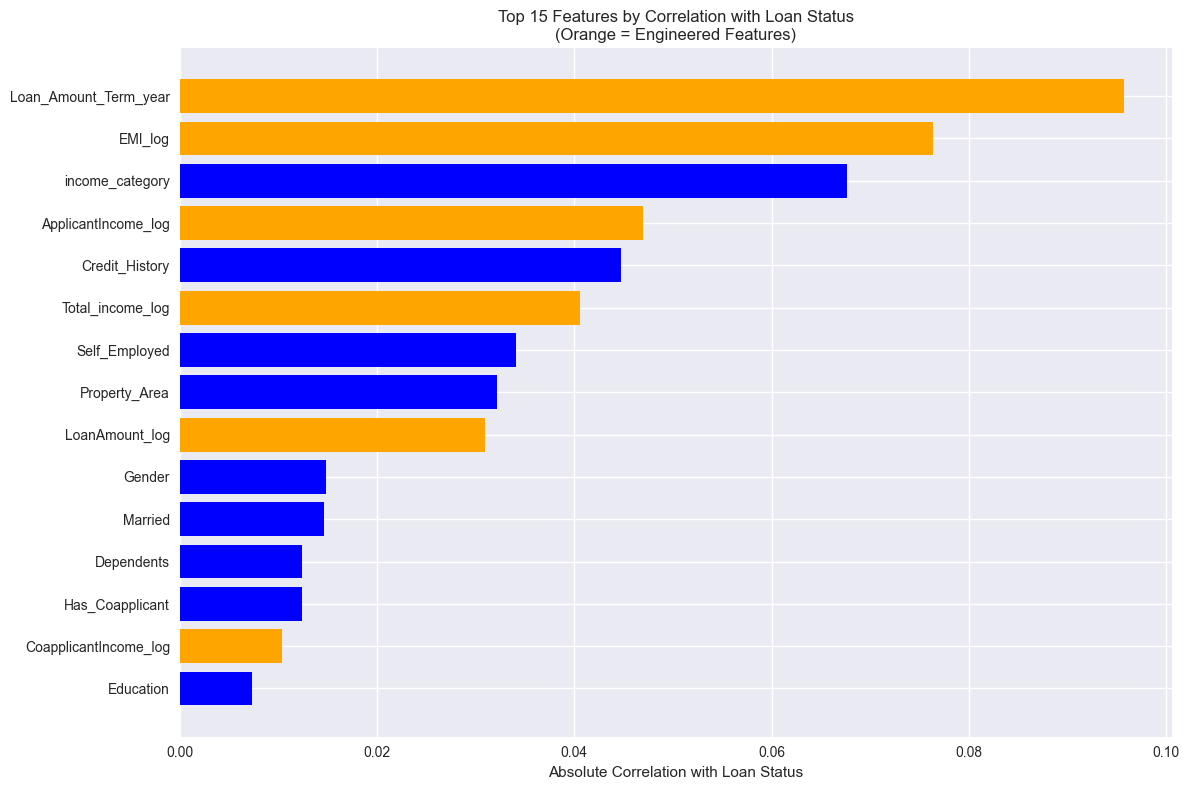


✓ Feature importance analysis completed
✓ 5 engineered features in top 10


In [535]:
# Feature importance analysis to validate EDA-based engineering
print("===FEATURE IMPORTANCE ANALYSIS===")

# Calculate correlation with target for all features
features_corr = scaled_X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with Loan Status")
for i, (feature, corr) in enumerate(features_corr.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in scaled_X_train.columns if any(keyword in col.lower() for keyword in ['year', 'total', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in features_corr.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = features_corr.head(15)
colors = ['orange' if any(keyword in f.lower() for keyword in ['year', 'total', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Loan Status')
plt.title('Top 15 Features by Correlation with Loan Status\n(Orange = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in features_corr.head(10).index])} engineered features in top 10")



#### **10. Save Preprocessed Data**

Save all preprocessed dataset and preprocessing objects for modeling

In [542]:
print("SAVING PREPROCESSED DATA")

# Save the scaled datasets (features)
scaled_X_train.to_csv('Scaled_X_train.csv', index=False)
scaled_X_test.to_csv('Scaled_X_test.csv', index=False)


# Save the target variables
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'selected_features.pkl')

# Save preprocessing objects
feature_importance_df = pd.DataFrame({'feature': features_corr.index, 'correlation': features_corr.values})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save Preprocessing summary
preprocessing_summary = {
    'original_shape': loan_train.shape,
    'final_shape': df_processed.shape,
    'selected_features': X.columns.tolist(),
    'engineered_features': engineered_features,
    'train_samples': scaled_X_train.shape[0],
    'test_samples': scaled_X_test.shape[0],
    'scaling_method': 'RobustScaler',
    'outlier_treatment': 'log Transformation',
    'log_transformed': ['ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_test_scaled.csv
- y_train.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


#### **11. Preprocessing Summary**

In [540]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {loan_train.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(X)}")
print(f"Training samples: {scaled_X_train.shape[0]}")
print(f"Test samples: {scaled_X_test.shape[0]}")

print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, no duplicated values)")
print("> Log-transformation of skewed variables ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI')")
print("> Feature engineering based on EDA recommendations:")
print(" - Total_Income = ApplicantIncome + Coapplicantincome")
print("  - Loan_Amount_Term_Year = Loan_Amount_Term / 12")
print("  - EMI = Loan_amount / Loan_Amount_Term_year")
print("  - Has_Coapplicant = Yes or No")
print("  - Income_category = Low, Medium, High and Very High")
print("> Feature selection ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI', 'Loan_Amount_Term')")
print("> SMOTE (Handles class imbalance)")
print("> RobustScaler applied (EDA recommendation)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")

print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> Skewed variables log-transformed as recommended")
print("> Features have been engineered")



print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")


.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (614, 12)
Final processed dataset shape: (614, 22)
Selected features: 844
Training samples: 675
Test samples: 169

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, no duplicated values)
> Log-transformation of skewed variables ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI')
> Feature engineering based on EDA recommendations:
 - Total_Income = ApplicantIncome + Coapplicantincome
  - Loan_Amount_Term_Year = Loan_Amount_Term / 12
  - EMI = Loan_amount / Loan_Amount_Term_year
  - Has_Coapplicant = Yes or No
  - Income_category = Low, Medium, High and Very High
> Feature selection ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI', 'Loan_Amount_Term')
> SMOTE (Handles class imbalance)
> RobustScaler applied (EDA recommendation)
> Feature importance analysis (validates engineered features)
> Data export (ready for m